<a href="https://colab.research.google.com/github/hinsley/colabs/blob/master/Coronavirus_Projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To Do

- [ ] Improve projections.
- [X] Change 68% confidence interval error bars to 95% or 99.7%.
- [X] Add US states projections for confirmed cases & deaths.
- [ ] Add Canadian provincial projections for confirmed cases & deaths.

### What can be done to improve projections?

- [ ] Do not factor zero values into dataset to fit curve to.
- [ ] Fit derivative curve instead of sigmoid curve.
- [ ] Try weighting newer values as more important.
- [ ] Use lognormal probability density function instead of sigmoid.

In [1]:
!pip install uncertainties

     |████████████████████████████████| 235kB 1.4MB/s 
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96456 sha256=27eae0131da1d81f81099c9704af5a73d6ced28002a9c0645fa6f89620de0e63
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built uncertainties


In [0]:
from uncertainties import ufloat
import numpy as np
import pandas as pd
from uncertainties import unumpy as unp
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from datetime import date, datetime, timedelta

In [0]:
def sigmoid(x, a, b, c):
  """
  Args:
  - x: Time input.
  - a: Horizontal translation (positive: right).
  - b: Vertical scalar.
  - c: Horizontal scalar.
  """

  result = b * (1-1/(1+np.exp(c * (x - a))))

  return result

def usigmoid(x, a, b, c):
  result = b * (1-1/(1+unp.exp(c * (x - a))))

  return result


# Finding projective maximum spread rate

$\sigma = b \left(1 - \frac{1}{1 + e^{c(x - a)}}\right)$

The maximum spread rate can be found by the spread rate $\sigma_x(x_\text{inflection})$ where
$\sigma_{xx}(x_\text{inflection}) = 0$.

$\sigma_x = -b \frac{\partial}{\partial x} \frac{1}{1+e^{c(x-a)}}$

$= b \frac{1}{(1+e^{c(x-a)})^2} \frac{\partial}{\partial x}(1+e^{c(x-a)})$

$= \frac{b}{(1+e^{c(x-a)})^2e^{ac}} \frac{\partial}{\partial x}(e^{cx})$

$= bc \frac{e^{c(x-a)}}{(1+e^{c(x-a)})^2}$

$= bc \frac{1 + e^{c(x-a)} - 1}{(1+e^{c(x-a)})^2}$

$= bc \left( \frac{1}{1 + e^{c(x-a)}} - \frac{1}{(1+e^{c(x-a)})^2} \right)$

$= bc \frac{1}{1+e^{c(x-a)}} \left( 1 - \frac{1}{1+e^{c(x-a)}} \right)$

$\sigma_x = \frac{c}{b} \sigma (b - \sigma)$

$\sigma_{xx} = \frac{c}{b} \frac{\partial}{\partial x}\left[\sigma(b-\sigma)\right]$

$= \frac{c}{b} \left[ \sigma_x (b - \sigma) - \sigma \sigma_{x} \right]$

$\sigma_{xx} = c (\sigma_x - \frac{2}{b}\sigma \sigma_x)$

From this derivation we can tell that the following equation must be true at the inflection point:

$\sigma_x = \frac{2}{b} \sigma \sigma_x$

$\sigma = \frac{b}{2}$

Returning to our definition of $\sigma$, we now have that:

$e^{c(x-a)} = 1$

and thus $x = a$, indicating that the maximum spread rate will be $\sigma_x(a)$.


In [0]:
def sigmoid_derivative(x, a, b, c):
  sigma = sigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def usigmoid_derivative(x, a, b, c):
  sigma = usigmoid(x, a, b, c)

  return c/b * sigma * (b - sigma)

def sigmoidal_max_daily_growth_rate(a, b, c):
  return usigmoid_derivative(a, a, b, c)

In [0]:
def log_growth_rate_domain(growth_rate_curve, *args):
  return unp.log(growth_rate_curve(*args))

In [0]:
def fit_growth(curve_function, xs, ys):
  """
  Args:
  - curve_function: A 3-parameter function of x that produces a growth rate at a
    particular time. The first parameter should be a vertical scalar (usually
    equal to supremum of cumulative time series). The second parameter should be
    a horizontal shift. The third parameter should control onset rate in some
    fashion.
  - xs: Times of data points in time series to fit curve to.
  - ys: Magnitudes of data points in time series to fit curve to.
  Returns:
  - If convergent, returns a list of ufloats containing nominal parameters for
    `curve_function` with standard deviations calculated from the fit's
    covariance matrix diagonal.
  - If divergent, returns None.
  """

  initial_guesses = [max(ys)/2, 0, 0]
  while True:
    try:
      popt, pcov = curve_fit(curve_function, xs, ys, p0=initial_guesses)
      break
    except RuntimeError: # Couldn't optimize after 800 adjustments...
      initial_guesses[0] = (initial_guesses[0] + 1) * 1.5
  
  convergent = all([param > 0 for
                    param in
                    popt]) and all([invcov != 0 for
                                    invcov in
                                    1/pcov.flatten()])
  
  if convergent:
    return [ufloat(*val_pair) for val_pair in zip(popt, np.sqrt(np.diag(pcov)))]

In [7]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv")

ts_df

Province/States    Country/Region  ... 3/20/2020  3/21/2020
0         Confirmed          Globally  ...  234073.0   266073.0
1            Deaths          Globally  ...    9840.0    11184.0
2         Confirmed             China  ...   81300.0    81416.0
3         Confirmed  Outside of China  ...  152773.0   184657.0
4            Deaths             China  ...    3253.0     3261.0
..              ...               ...  ...       ...        ...
223          Deaths               NaN  ...    1312.0     1466.0
224       Confirmed               NaN  ...   13271.0    18877.0
225          Deaths               NaN  ...     178.0      235.0
226       Confirmed               NaN  ...     473.0      572.0
227          Deaths               NaN  ...       8.0       12.0

[228 rows x 64 columns]

# Confirmed Cases

## By Country

### Aggregated

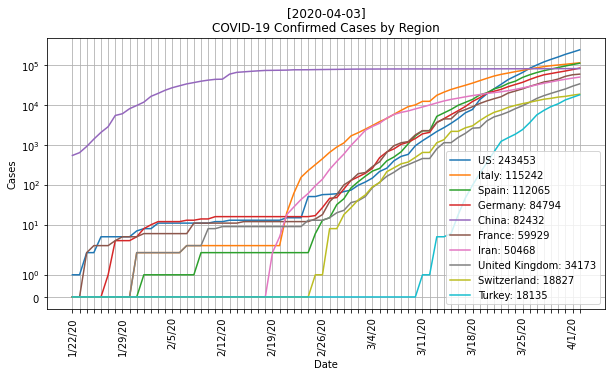

In [8]:
ts_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

ts_only_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_confirmed_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}]\nCOVID-19 Confirmed Cases by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_confirmed_df.index[:legend_size]:
  ax.plot(ts_only_confirmed_df.loc[region], label=f"{region}: {ts_only_confirmed_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Cases")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

In [9]:
ts_global_confirmed_df = ts_confirmed_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_global_confirmed_df

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
3/29/20     720117
3/30/20     782365
3/31/20     857487
4/1/20      932605
4/2/20     1013157
Length: 72, dtype: object

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


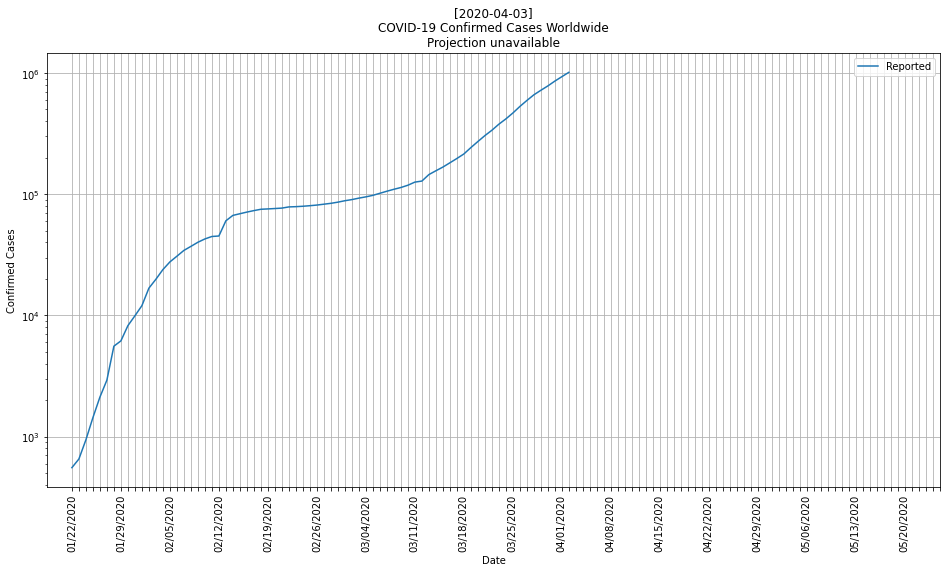

In [10]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_global_confirmed_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
fig, ax = plt.subplots(1, figsize=(16, 8))

days_to_plot = 125

if u_popt is not None:
  u_ys = [curve(x) for x in range(days_to_plot)]
  ax.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
ax.errorbar(x=range(ts_global_confirmed_df.size), y=ts_global_confirmed_df, label="Reported")

ax.set_title(f"[{date.today()}]\nCOVID-19 Confirmed Cases Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")

day_zero = datetime(2020, 1, 22, 0, 0)

ax.set_xticks(range(days_to_plot))
ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

plt.setp(ax.get_xmajorticklabels(), rotation=90)

i = 0
for label in ax.get_xmajorticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

ax.grid()
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")

plt.show()

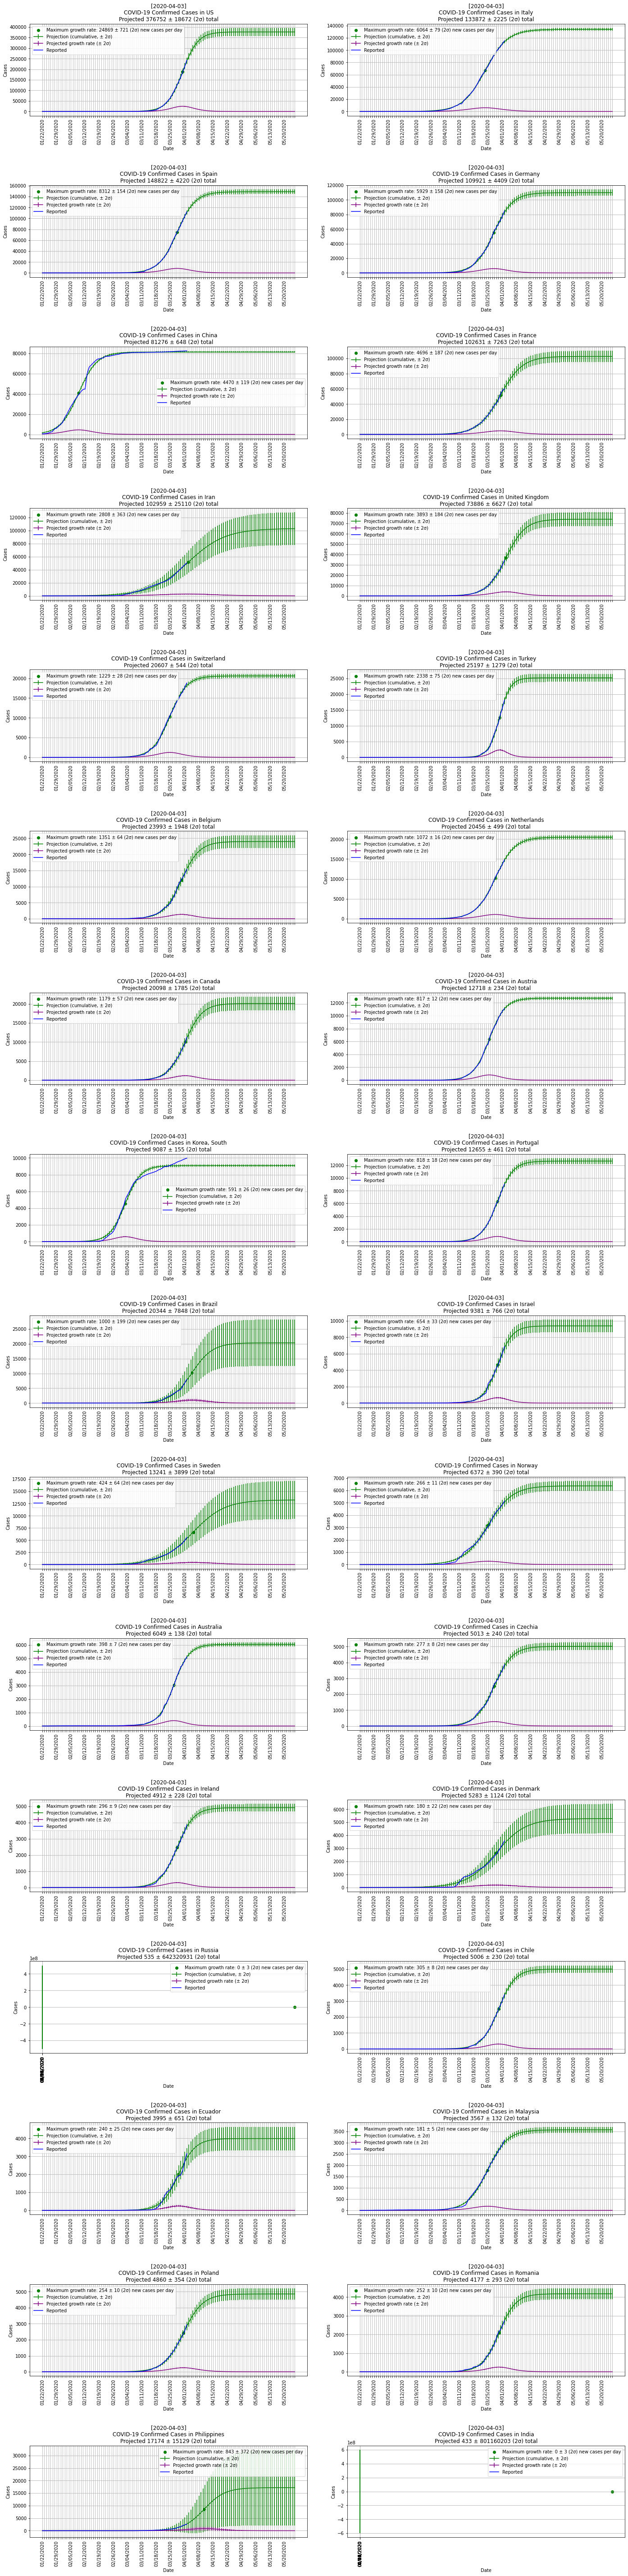

In [11]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_confirmed_df[:min(plot_top_n_countries, len(ts_only_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}]\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} ± {int(inflection_y.std_dev)} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [12]:
ts_us_confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

ts_us_confirmed_df = ts_us_confirmed_df.drop(["UID", "iso2", "iso3", "code3",
                                              "FIPS", "Admin2",
                                              "Country_Region", "Lat", "Long_",
                                              "Combined_Key"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_confirmed_df

1/22/20  1/23/20  1/24/20  ...  3/31/20  4/1/20  4/2/20
Province_State                                       ...                         
New York                        0        0        0  ...    75833   83948   92506
New Jersey                      0        0        0  ...    18696   22255   25590
Michigan                        0        0        0  ...     7615    9315   10791
California                      0        0        0  ...     8210    9399   10773
Louisiana                       0        0        0  ...     5237    6424    9159
Florida                         0        0        0  ...     6741    6956    9008
Massachusetts                   0        0        0  ...     6620    7738    8966
Illinois                        0        0        1  ...     5994    6980    7695
Pennsylvania                    0        0        0  ...     4963    6009    7268
Washington                      1        1        1  ...     5432    5608    6389
Georgia                         0        0        0  ...     3929    4638    5348
Texas                           0        0        0  ...     3809    4355    5069
Connecticut                     0        0        0  ...     3128    3557    3824
Colorado                        0        0        0  ...     2966    2982    3342
Indiana                         0        0        0  ...     2158    2564    3038
Ohio                            0        0        0  ...     2199    2547    2901
Tennessee                       0        0        0  ...     2391    2933    2845
Maryland                        0        0        0  ...     1660    1986    2331
North Carolina                  0        0        0  ...     1535    1675    1977
Missouri                        0        0        0  ...     1357    1613    1857
Wisconsin                       0        0        0  ...     1412    1556    1748
Arizona                         0        0        0  ...     1289    1530    1715
Virginia                        0        0        0  ...     1249    1483    1706
South Carolina                  0        0        0  ...     1083    1293    1554
Nevada                          0        0        0  ...     1114    1279    1463
Alabama                         0        0        0  ...      987    1060    1233
Mississippi                     0        0        0  ...      937    1073    1177
Utah                            0        0        0  ...      888     888    1092
Oklahoma                        0        0        0  ...      568     721     881
Oregon                          0        0        0  ...      690     736     826
Idaho                           0        0        0  ...      515     566     776
Kentucky                        0        0        0  ...      628     632     770
Minnesota                       0        0        0  ...      629     689     742
Rhode Island                    0        0        0  ...      488     566     657
District of Columbia            0        0        0  ...      495     586     653
Arkansas                        0        0        0  ...      523     584     643
Iowa                            0        0        0  ...      497     547     614
Kansas                          0        0        0  ...      434     485     553
Delaware                        0        0        0  ...      319     368     393
New Mexico                      0        0        0  ...      315     340     388
Maine                           0        0        0  ...      303     303     376
Vermont                         0        0        0  ...      293     321     338
Puerto Rico                     0        0        0  ...      239     286     316
New Hampshire                   0        0        0  ...      357     357     316
Hawaii                          0        0        0  ...      204     224     256
Nebraska                        0        0        0  ...      172     210     246
Montana                         0        0        0  ...      198     208     241
West Vir

### Projections

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


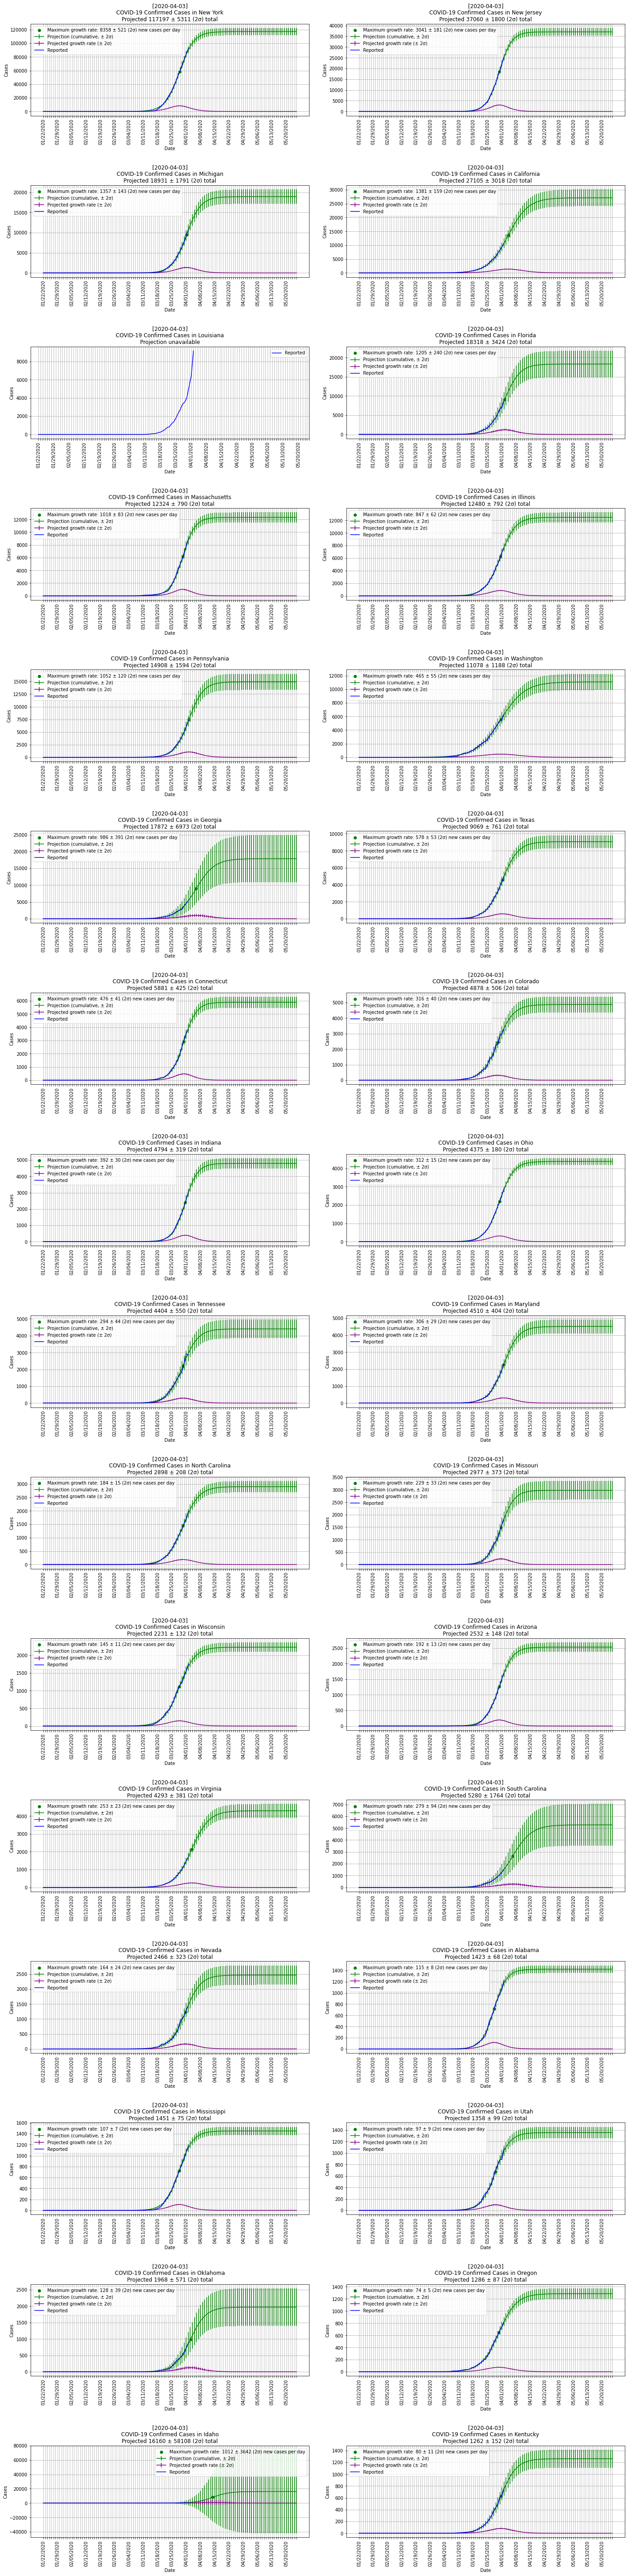

In [13]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_confirmed_df[:min(plot_top_n_states, len(ts_us_confirmed_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}]\nCOVID-19 Confirmed Cases in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")
  current_ax.set_ylabel("Cases")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} ± {int(inflection_y.std_dev * 2)} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

# Deaths

## By Country

### Aggregated

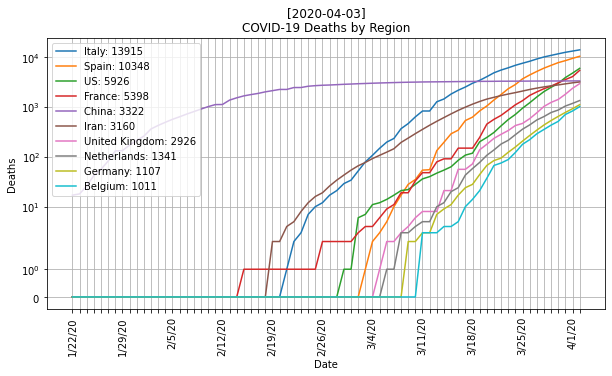

In [14]:
ts_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

ts_only_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).groupby("Country/Region").sum().sort_values(list(ts_deaths_df)[-1], ascending=False)

plt.figure(figsize=(10, 5))

ax = plt.subplot()


plt.title(f"[{date.today()}]\nCOVID-19 Deaths by Region")

ax.grid(which="major")
plt.xticks(rotation="vertical")

legend_size = 10

for region in ts_only_deaths_df.index[:legend_size]:
  ax.plot(ts_only_deaths_df.loc[region], label=f"{region}: {ts_only_deaths_df.loc[region][-1]}")

ax.legend()
plt.yscale("symlog")
plt.ylabel("Deaths")
plt.xlabel("Date")

i = 0
for label in ax.xaxis.get_ticklabels():
  if i % 7 != 0:
    label.set_visible(False)
  i += 1

plt.show()

### Projections

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


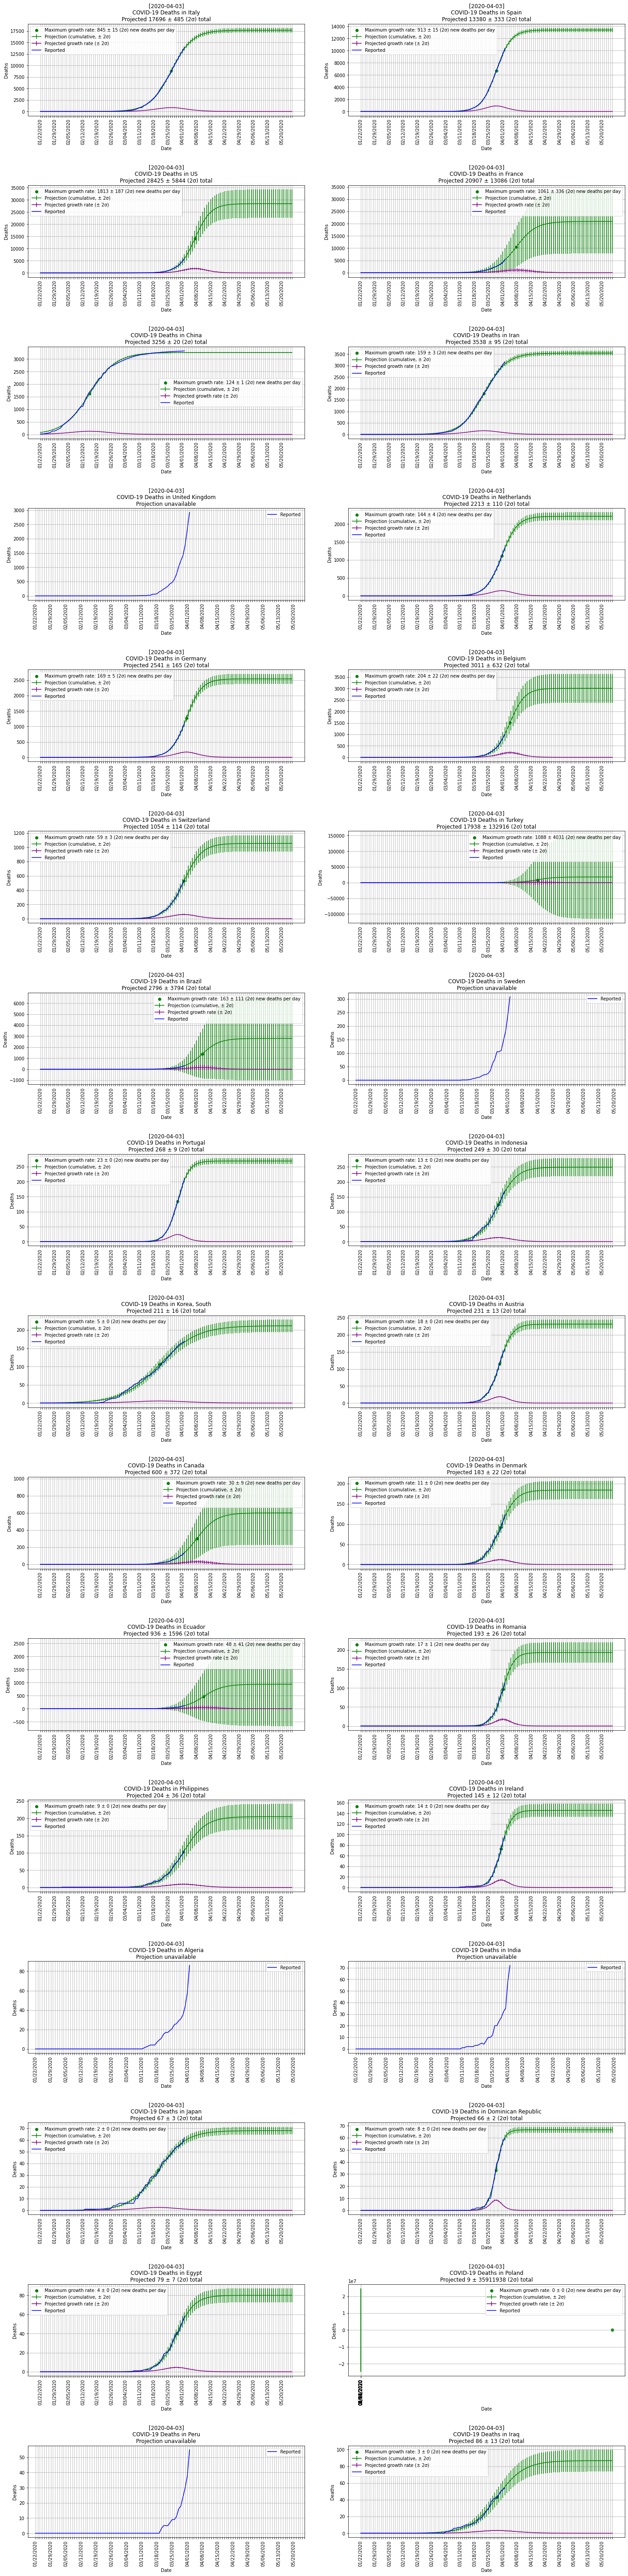

In [15]:
plot_top_n_countries = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_only_deaths_df[:min(plot_top_n_countries, len(ts_only_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)
  
  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}]\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(x) for x in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} ± {int(inflection_y.std_dev)} (2σ) new deaths per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By United States state / territory

In [16]:
ts_us_deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

ts_us_deaths_df = ts_us_deaths_df.drop(["UID", "iso2", "iso3", "code3",
                                           "FIPS", "Admin2",
                                           "Country_Region", "Lat", "Long_",
                                           "Combined_Key", "Population"], axis=1).groupby("Province_State").sum().sort_values(list(ts_us_confirmed_df)[-1], ascending=False)

ts_us_deaths_df

1/22/20  1/23/20  1/24/20  ...  3/31/20  4/1/20  4/2/20
Province_State                                       ...                         
New York                        0        0        0  ...     1550    1941    2373
New Jersey                      0        0        0  ...      267     355     537
Michigan                        0        0        0  ...      259     335     417
Louisiana                       0        0        0  ...      239     273     310
Washington                      0        0        0  ...      225     234     271
California                      0        0        0  ...      173     199     238
Florida                         0        0        0  ...       85      87     164
Georgia                         0        0        0  ...      111     139     163
Illinois                        0        0        0  ...       99     141     163
Massachusetts                   0        0        0  ...       89     122     154
Connecticut                     0        0        0  ...       69      85     112
Pennsylvania                    0        0        0  ...       63      74      90
Ohio                            0        0        0  ...       55      65      81
Colorado                        0        0        0  ...       69      69      80
Indiana                         0        0        0  ...       49      65      78
Texas                           0        0        0  ...       54      66      77
Virginia                        0        0        0  ...       27      34      41
Wisconsin                       0        0        0  ...       25      27      38
Nevada                          0        0        0  ...       26      31      38
Tennessee                       0        0        0  ...       23      24      36
Maryland                        0        0        0  ...       18      31      36
Oklahoma                        0        0        0  ...       23      30      34
Alabama                         0        0        0  ...       23      27      32
Arizona                         0        0        0  ...       24      29      32
Kentucky                        0        0        0  ...       11      18      31
South Carolina                  0        0        0  ...       22      26      31
Mississippi                     0        0        0  ...       20      22      26
Missouri                        0        0        0  ...       15      18      22
North Carolina                  0        0        0  ...       12      14      21
Oregon                          0        0        0  ...       18      19      21
Minnesota                       0        0        0  ...       12      17      18
Vermont                         0        0        0  ...       13      16      17
Arkansas                        0        0        0  ...        8      10      12
Kansas                          0        0        0  ...        9      10      12
Delaware                        0        0        0  ...       10      11      12
District of Columbia            0        0        0  ...        9       9      12
Puerto Rico                     0        0        0  ...        8      11      12
Rhode Island                    0        0        0  ...        8      10      12
Iowa                            0        0        0  ...        7       9      11
Idaho                           0        0        0  ...        8       9       9
Maine                           0        0        0  ...        5       5       7
Utah                            0        0        0  ...        5       5       7
New Mexico                      0        0        0  ...        4       5       6
Montana                         0        0        0  ...        5       6       6
Nebraska                        0        0        0  ...        3       4       5
Grand Princess                  0        0        0  ...        3       3       3
Guam                            0        0        0  ...        2       3       3
Alaska  

### Projections

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


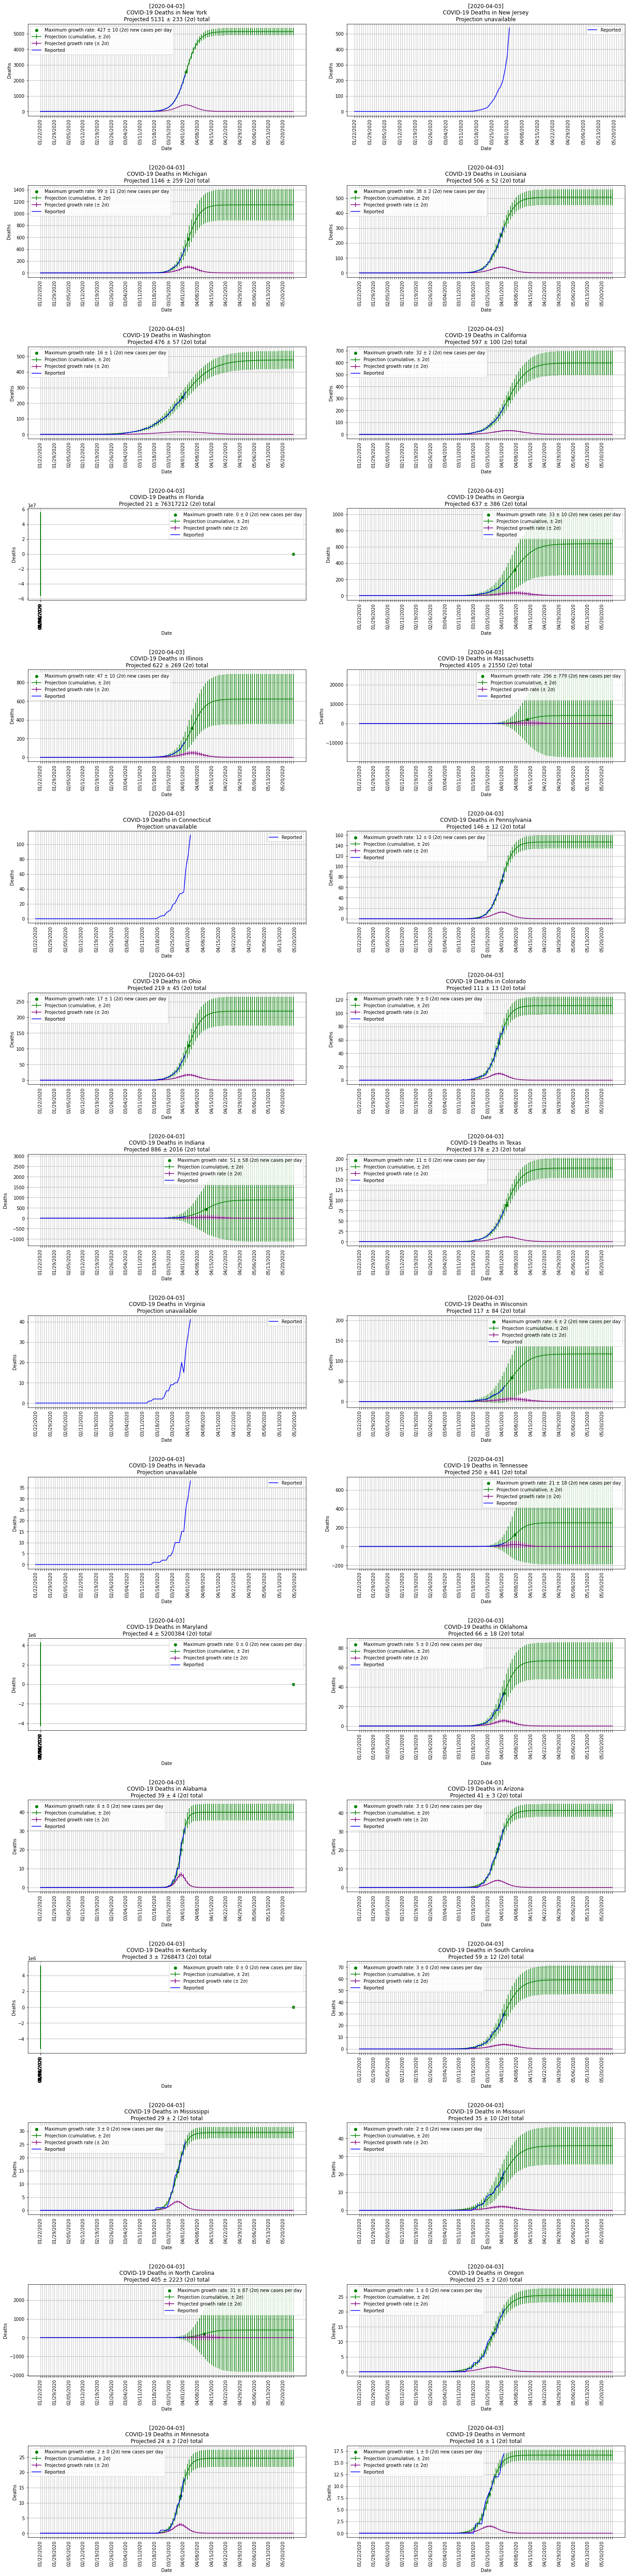

In [17]:
plot_top_n_states = 32

columns = 2
scaling = 10, 5

ts_plot_df = ts_us_deaths_df[:min(plot_top_n_states, len(ts_us_deaths_df))]

rows = math.ceil(len(ts_plot_df)/columns)
fig, axs = plt.subplots(rows, columns,
                        figsize=(columns * scaling[0], rows * scaling[1]))

subplot = 0
for region in ts_plot_df.index:
  current_ax = axs[math.floor(subplot/columns), subplot % columns]
  subplot += 1

  regional_ts = ts_plot_df.loc[region]

  xs, ys = zip(*enumerate(regional_ts))
  u_popt = fit_growth(sigmoid, xs, ys)

  if u_popt is not None:
    curve = lambda x: usigmoid(x, *u_popt)
    curve_derivative = lambda x: usigmoid_derivative(x, *u_popt)

  current_ax.set_title(f"[{date.today()}]\nCOVID-19 Deaths in {region}\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")
  current_ax.set_ylabel("Deaths")
  current_ax.set_xlabel("Date")

  days_to_plot = 125

  if u_popt is not None:
    u_ys = [curve(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (cumulative, ± 2σ)", color="green")
    u_ys_prime = [curve_derivative(day) for day in range(days_to_plot)]
    current_ax.errorbar(x=range(days_to_plot), y=[u_y_prime.nominal_value for u_y_prime in u_ys_prime], yerr=[u_y_prime.std_dev * 2 for u_y_prime in u_ys_prime], label="Projected growth rate (± 2σ)", color="purple")
    inflection_y = sigmoidal_max_daily_growth_rate(*u_popt)
    current_ax.scatter(x=u_popt[0].nominal_value, y=sigmoid(u_popt[0].nominal_value, *[p.nominal_value for p in u_popt]), label=f"Maximum growth rate: {int(inflection_y.nominal_value)} ± {int(inflection_y.std_dev)} (2σ) new cases per day", color="green")

  current_ax.errorbar(x=range(len(regional_ts)), y=regional_ts, label="Reported", color="blue")

  plt.setp(current_ax.get_xmajorticklabels(), rotation=90)

  day_zero = datetime(2020, 1, 22, 0, 0)

  current_ax.set_xticks(range(days_to_plot))
  current_ax.set_xticklabels([(day_zero + timedelta(days=x)).strftime("%m/%d/%Y") for x in range(days_to_plot)])

  i = 0
  for label in current_ax.get_xmajorticklabels():
    if i % 7 != 0:
      label.set_visible(False)
    i += 1

  current_ax.grid()
  current_ax.legend()

fig.tight_layout(pad=3)

plt.show()

## By Country

### Aggregated

In [18]:
ts_only_consol_deaths_df = ts_deaths_df.drop(["Lat", "Long"], axis=1).sum()[1:]

ts_only_consol_deaths_df

1/22/20       17
1/23/20       18
1/24/20       26
1/25/20       42
1/26/20       56
           ...  
3/29/20    33925
3/30/20    37582
3/31/20    42107
4/1/20     46809
4/2/20     52983
Length: 72, dtype: object

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


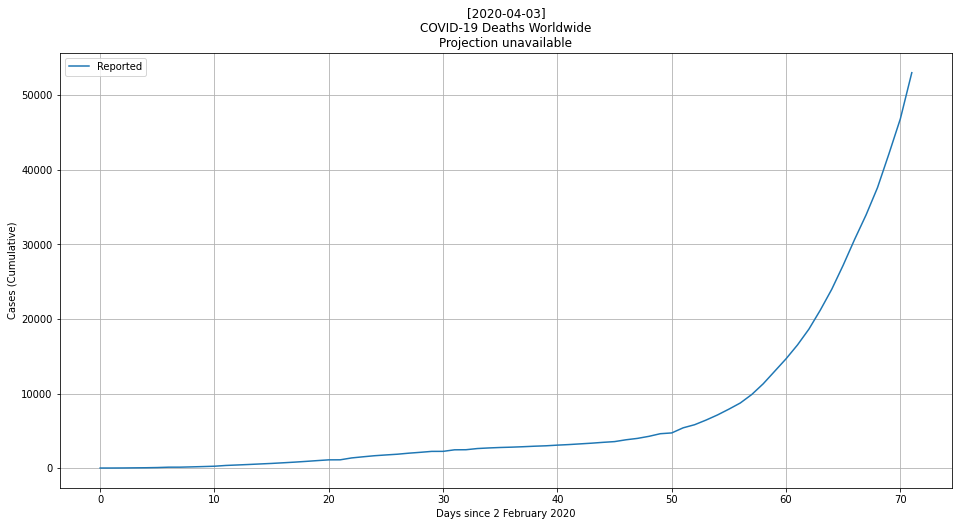

In [19]:
u_popt = fit_growth(sigmoid, *zip(*enumerate(ts_only_consol_deaths_df)))

if u_popt is not None:
  curve = lambda x: usigmoid(x, *u_popt)

# Prediction.
plt.figure(figsize=(16, 8))
if u_popt is not None:
  u_ys = [curve(x) for x in range(200)]
  plt.errorbar(x=range(len(u_ys)), y=[u_y.nominal_value for u_y in u_ys], yerr=[u_y.std_dev * 2 for u_y in u_ys], label="Projection (± 2σ)")
plt.errorbar(x=range(ts_only_consol_deaths_df.size), y=ts_only_consol_deaths_df, label="Reported")

plt.title(f"[{date.today()}]\nCOVID-19 Deaths Worldwide\n{'Projection unavailable' if u_popt is None else f'Projected {int(u_popt[1].nominal_value)} ± {int(u_popt[1].std_dev * 2)} (2σ) total'}")
plt.grid()
plt.xlabel("Days since 2 February 2020")
plt.ylabel("Cases (Cumulative)")
#plt.yscale("symlog")
plt.legend()

plt.show()